In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import random
from pprint import pprint

from django.conf.urls import include

import math
from statistics import *

from sklearn.metrics import mean_squared_error

import time

In [6]:
class dtree:
#     initializing the final dataframes that will be formed after replacing NAN values
    new_dataset= pd.DataFrame()
    new_testset= pd.DataFrame()
    
#     columns that have continous data
    num_cols= [0,2,3,15,16,24,32,34,35,36,41,42,43,44,45,46,47,48,49,50,52,54,58,59,63,64,65,66,67,68,69,70]
#     columns that have categorical data
    cat_cols=[]
         
#     the initial dataset and testset
    dataset= []
    test_data= []
    
    temp_data=[]
#     the headings of the columns
    column_headers=[]
#     maximum depth of the tree
    depth= 0
#     min_samples required in a datframe to continue the recursion
    min_samples= 10
#     instantiate the tree
    tree={}
    
#     the training phase of the algorithm
    def train(self, filename):
#         evaluating the categorical coloumns from the numerical columns
        for i in range (1, 74):
            if(self.num_cols.count(i)==0):
                self.cat_cols.append(i)
        
#         reading the csv train file
        self.dataset= pd.read_csv(filename)
#         data visualization to check which attributes have maximum null values
        missing_val_count_by_column = (self.dataset.isnull().sum())
        print(missing_val_count_by_column[missing_val_count_by_column > 0].plot(kind='bar'))
        
        time.sleep(10)
        
#         drop the majority nan valued columns
        self.dataset = self.dataset.drop(["Id", "Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu"], axis=1)
    
#         storing the columns names (attribute names)
        self.column_headers= self.dataset.columns
#         converting dataset into numpy to ensure faster calculations
        self.dataset= self.dataset.to_numpy()
#         replacing the nan values with the column's mean for continous data and by mode for categorical data
        for i in range (0, 74):
            if(self.num_cols.count(i) >0):
                self.apply_mean_train(i)
            else:
                self.apply_mode_train(i)
                
#         finally appending the price label to the dataframe
        list=[]
        for j in range(0, len(self.dataset)):
            list.append(self.dataset[j][74])
        df= pd.DataFrame(list)
        self.new_dataset= pd.concat([self.new_dataset, df], axis= 1)
        
        
        self.new_dataset= self.new_dataset.to_numpy()
        self.split_data_temp()
        self.new_dataset= pd.DataFrame(self.new_dataset)
        
        #start algorithm to build decision tree
        self.tree =self.decision_tree_algo(self.new_dataset)
        
#         print the formed tree
        pprint(self.tree, width=20)
    
    def split_data_temp(self):
        random.shuffle(self.new_dataset)
#         self.new_dataset = self.new_dataset[int(0.9*len(self.new_dataset)):]
    
#     the prediction phase
    def predict(self, filename):
#         reading the test csv file
        self.test_data= pd.read_csv(filename)
    
#         drop the majority nan valued columns
        self.test_data = self.test_data.drop(["Id", "Alley", "PoolQC", "Fence", "MiscFeature", "FireplaceQu"], axis=1)
        
#         converting testset into numpy to ensure faster calculations
        self.test_data= self.test_data.to_numpy()
    
#         replacing the nan values with the column's mean for continous data and by mode for categorical data
        for i in range (0, 74):
            if(self.num_cols.count(i) >0):
                self.apply_mean_test(i)
            else:
                self.apply_mode_test(i)
                
#         list to store the predicted_prices    
        predicted_prices=[]
    
#         start_prediction for every row
        self.new_testset= self.new_testset.to_numpy()
        for row in self.new_testset:
            label= self.predict_price(row, self.tree)
            predicted_prices.append(label)
        return predicted_prices
      
    def decision_tree_algo(self, data):
        
#         base case
        if ((len(data) < self.min_samples) or (self.depth>5)):
            classification= self.classify_data(data)
            
            return classification
#         recursive part
        else:
#             increase the tree depth for every recurssion
            self.depth +=1
    
#             calculate the best_split_columns and best_split_value correspondingly
            split_col, split_value= self.get_best_split(data)
    
#             split the data according to the split_col and split_value
            df_left, df_right= self.split_data(data, split_col, split_value)

#             extract the feature name using cloumn-headers
            feature_name= self.column_headers[split_col]

            if(self.num_cols.count(split_col)>0):
                question = "{} <= {}".format(feature_name, split_value)

            else:
                question = "{} = {}".format(feature_name, split_value)

            sub_tree= {question: []}
            
#             perform decision tree algorithm for both right and left subtrees
            yes= self.decision_tree_algo(df_left)
            no= self.decision_tree_algo(df_right)

            if yes== no:
                sub_tree= yes
            else:
                sub_tree[question].append(yes)
                sub_tree[question].append(no)

            return sub_tree
    
#     return the mean of all the prices at the leaf node
    def classify_data(self,data):
        label_col= data[data.columns[-1]]
        classification= mean(label_col)
        
        return classification
    
#     return the best split column and value corresponding
    def get_best_split(self, data):
        potential_splits= {}
        for index in range(0, 73):
            potential_splits[index]= []
            values= data.iloc[:, index]
            unique_values= set(values)
            
#             check if the feature is numerical
            if(self.num_cols.count(index)>0):
#                 sort the unique-classes for optimization
                unique_values =sorted(unique_values, reverse= False)
                for unique in unique_values:
#                     if there is a single unique-class
                    if(len(unique_values)-1 ==1):
                        potential_splits[index].append(self.potential_numerical_split(data, index, unique))
                    else:
                        avg= (unique+ unique+1)/2
                        potential_splits[index].append(self.potential_numerical_split(data, index, avg))
                        
#             the feature is categorical
            else:
                for unique in unique_values:
                    potential_splits[index].append(self.potential_category_split(data, index, unique))
            
#         consider a maximum value for overall mse
        overall_mse= 99999999999999999999
        best_split_col= 0
        best_split_value= 0
        
#         run through the list of potential splits and obtain overall minimum MSE and corresponding split column and value
        for split in potential_splits:
            for expect in potential_splits[split]:
                split_value= expect[0]
                current_mse= expect[1]
                if(current_mse <= overall_mse):
                    overall_mse =current_mse
                    best_split_col= split
                    best_split_value= split_value
                        
        return best_split_col, best_split_value
        
#     evaluate potenial splits for categorical data
    def potential_category_split(self, data, index, unique):
        df_left=pd.DataFrame()
        df_right=pd.DataFrame()
        
        for j in range(0, len(data)):
#             if the current class is equal to the current row's 'unique' attribute append to the left dataframe
            if(data.iloc[j, index] == unique):
                df= pd.DataFrame(data.iloc[j, :])
                df_left= pd.concat([df_left, df], axis= 1)
                
#             if the current class is not equal to the current row's 'unique' attribute append to the right dataframe
            else:
                df= pd.DataFrame(data.iloc[j, :])
                df_right= pd.concat([df_right, df], axis= 1)
        
#         transpose the dataframes to get the actual data shape
        df_left= df_left.transpose()
        df_right= df_right.transpose()

        left_mean=0
        right_mean=0
        
#         calculate the mean_prices of the left dataframe formed
        if(len(df_left)):
            ans= df_left[df_left.columns[-1]].to_numpy()
            m= mean(ans)
            for j in range (0,len(df_left)):
                left_mean+= (df_left.iloc[j, -1]- m)**2
                
#         calculate the mean_prices of the right dataframe        
        if(len(df_right)):
            ans= df_right[df_right.columns[-1]].to_numpy()
            m= mean(ans)
            for j in range (0,len(df_right)):
                right_mean+= (df_right.iloc[j, -1]- m)**2
        
#         calculate the weighted mean 
        mean_value= (left_mean*len(df_left)+ right_mean*len(df_right))/len(data)
        
#         append the unique class and corresponding mean value to the result
        result=[unique, mean_value]
        return result
    
#     evaluate potenial splits for numerical data
    def potential_numerical_split(self, data, index, unique):
        df_left=pd.DataFrame()
        df_right=pd.DataFrame()
        for j in range(0, len(data)):
#             if the current class is less than or equal to the current row's 'unique' attribute append to the left dataframe
            if(data.iloc[j, index] <= unique):
                df= pd.DataFrame(data.iloc[j, :])
                df_left= pd.concat([df_left, df], axis= 1)

#             if the current class is greater to the current row's 'unique' attribute append to the right dataframe
            else:
                df= pd.DataFrame(data.iloc[j, :])
                df_right= pd.concat([df_right, df], axis=1)

#         transpose the dataframes to get the actual data shape
        df_left= df_left.transpose()
        df_right= df_right.transpose()

        left_mean=0
        right_mean=0
        
#         calculate the mean_prices of the left dataframe formed
        if(len(df_left)>0):
            ans= df_left[df_left.columns[-1]].to_numpy()
            m= mean(ans)
            for j in range (0,len(df_left)):
                left_mean+= (df_left.iloc[j, -1]- m)**2
                
#         calculate the mean_prices of the right dataframe
        if(len(df_right)):
            ans= df_right[df_right.columns[-1]].to_numpy()
            m= mean(ans)
            for j in range (0,len(df_right)):
                right_mean+= (df_right.iloc[j, -1]- m)**2
        
#         calculate the weighted mean 
        mean_value= (left_mean*len(df_left)+ right_mean*len(df_right))/len(data)
    
#         append the unique class and corresponding mean value to the result
        result=[unique, mean_value]
        return result
    
#     replace the train_data with mean values of corresponding columns for numerical data  
    def apply_mean_train(self, i):
        current=[]
        for j in range (0, len(self.dataset)):
            current.append(self.dataset[j][i])

        mean= np.nanmean(np.asarray(current))
        for j in range (0, len(self.dataset)):
            if(math.isnan(current[j])):
                current[j]= mean
        
        df= pd.DataFrame(current)
        self.new_dataset= pd.concat([self.new_dataset, df], axis= 1)
        
#     replace the train_data with mode values of corresponding columns for categorical data    
    def apply_mode_train(self, i):
        current=[]
        for j in range (0, len(self.dataset)):
            current.append(self.dataset[j][i])
            
        mode= max(set(current), key=current.count)
        
        for j in range (0, len(self.dataset)):
            if(str(current[j]) == 'nan'):
                current[j]= mode
            
        df= pd.DataFrame(current)
        self.new_dataset= pd.concat([self.new_dataset, df], axis= 1)
        
#     replace the test_data with mean values of corresponding columns for numerical data
    def apply_mean_test(self, i):
        current=[]
        for j in range (0, len(self.test_data)):
            current.append(self.test_data[j][i])

        mean= np.nanmean(current)
        for j in range (0, len(self.test_data)):
            if(math.isnan(current[j])):
                current[j]= mean

        df= pd.DataFrame(current)
        self.new_testset= pd.concat([self.new_testset, df], axis= 1)
    
#     replace the test_data with mean values of corresponding columns for categorical data
    def apply_mode_test(self, i):
        current=[]
        for j in range (0, len(self.test_data)):
            current.append(self.test_data[j][i])
            
        mode= max(set(current), key=current.count)
        
        for j in range (0, len(self.test_data)):
            if(current[j] =='nan'):
                current[j]= mode
            
        df= pd.DataFrame(current)
        self.new_testset= pd.concat([self.new_testset, df], axis= 1)
    
#     splitting the data into left and right dataframes
    def split_data(self, data, split_col, split_val):
        df_left=pd.DataFrame()
        df_right=pd.DataFrame()
        
#         numerical features
        if(self.num_cols.count(split_col)>0):
            for j in range(0, len(data)):
                if(data.iloc[j, split_col] <= split_val):
                    df= pd.DataFrame(data.iloc[j, :])
                    df_left= pd.concat([df_left, df], axis= 1)


                else:
                    df= pd.DataFrame(data.iloc[j, :])
                    df_right= pd.concat([df_right, df], axis= 1)

            df_left= df_left.transpose()
            df_right= df_right.transpose()
        
#         categorical features
        else:
            for j in range(0, len(data)):
                if(data.iloc[j, split_col] == split_val):
                    df= pd.DataFrame(data.iloc[j, :])
                    df_left= pd.concat([df_left, df], axis= 1)


                else:
                    df= pd.DataFrame(data.iloc[j, :])
                    df_right= pd.concat([df_right, df], axis= 1)

            df_left= df_left.transpose()
            df_right= df_right.transpose()
        
        return df_left, df_right
    
#     do the prediction
    def predict_price(self, row, tree):
        question =list(tree.keys())[0]
        feature_name, comparision_operator, value= question.split(" ")
        
        feature_index=0
        for i in range (0, len(self.column_headers)):
            if(self.column_headers[i] == str(feature_name)):
                feature_index= i
                break
        x=1        
        while(x==1):
            x=0
        
        if comparision_operator== "<=":
            if row[feature_index] <= float(value):
                answer =tree[question][0]
            else:
                answer= tree[question][1]

                
        else:
            if str(row[feature_index]) == value:
                answer= tree[question][0]
            else:
                answer= tree[question][1]
                
        if(False):
            print()
                
        if not isinstance(answer, dict):
            return answer
        
        else:
            residual_tree= answer
            return self.predict_price(row, residual_tree)
        
    
        

AxesSubplot(0.125,0.125;0.775x0.755)
{'OverallQual <= 6.5': [{'1stFlrSF <= 1077.5': [{'GarageArea <= 264.5': [{'GarageArea <= 200.5': [61850,
                                                                                                  106167.33333333333]},
                                                                         {'BsmtFinSF1 <= 403.5': [{'OverallQual <= 4.5': [89133.33333333333,
                                                                                                                          121271.42857142857]},
                                                                                                  143554.54545454544]}]},
                                                155259.37037037036]},
                        265129.85714285716]}
MEAN SQUARED ERROR =  3200248006.675125


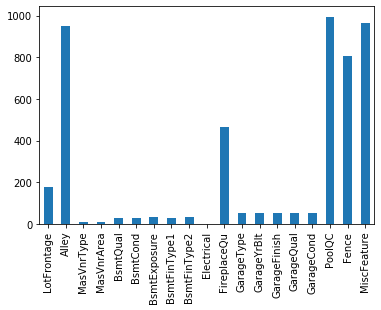

In [7]:
dtree_regressor = dtree()
dtree_regressor.train('/home/smriti/Downloads/train.csv')
predictions = dtree_regressor.predict('/home/smriti/Downloads/test.csv')
test_labels = list()
with open("/home/smriti/Downloads/test_labels.csv") as f:
  for line in f:
    test_labels.append(float(line.split(',')[1]))
    

print ("MEAN SQUARED ERROR = ", mean_squared_error(test_labels, predictions))